# Challenge
Now that you've learned about random forests and decision trees let's do an exercise in accuracy. You know that random forests are basically a collection of decision trees. But how do the accuracies of the two models compare?

So here's what you should do. Pick a dataset. It could be one you've worked with before or it could be a new one. Then build the best decision tree you can.

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. Compare that to the runtime of the decision tree. This is imperfect but just go with it.

Hopefully out of this you'll see the power of random forests, but also their potential costs. Remember, in the real world you won't necessarily be dealing with thousands of rows. It could be millions, billions, or even more.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import ensemble

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

%matplotlib inline

In [33]:
y2015 = pd.read_csv('LoanStats3d.csv', skipinitialspace=True, header=1)

# Note the warning about dtypes

/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [34]:
# Convert ID and Interest Rate to numeric
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')
y2015

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,60 months,14.85,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,36 months,7.49,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,36 months,7.49,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,36 months,6.49,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,36 months,19.89,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,D2,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,E3,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,B5,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Remove two summary rows at the end that don't actually contain data
y2015 = y2015[:-2]
y2015

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,60 months,14.85,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,36 months,7.49,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,36 months,7.49,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,36 months,6.49,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,36 months,19.89,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421090,36371250.0,39102635.0,10000.0,10000.0,10000.0,36 months,11.99,332.10,B,B5,...,0.0,1.0,100.0,100.0,0.0,0.0,32950.0,25274.0,9200.0,15850.0
421091,36441262.0,39152692.0,24000.0,24000.0,24000.0,36 months,11.99,797.03,B,B5,...,0.0,2.0,56.5,100.0,0.0,0.0,152650.0,8621.0,9000.0,0.0
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,D2,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,E3,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0


In [36]:
# Keep only the numerical variables and drop columns with NaN
num_variables = y2015.select_dtypes(include=['float64'])
num_variables = num_variables.dropna(axis=1)
num_variables

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0.0,0.0,2.0,78.9,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0.0,0.0,2.0,100.0,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0.0,0.0,0.0,100.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0.0,0.0,0.0,91.7,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0.0,0.0,12.0,100.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421090,36371250.0,39102635.0,10000.0,10000.0,10000.0,11.99,332.10,31000.0,28.69,0.0,...,0.0,0.0,1.0,100.0,0.0,0.0,32950.0,25274.0,9200.0,15850.0
421091,36441262.0,39152692.0,24000.0,24000.0,24000.0,11.99,797.03,79000.0,3.90,0.0,...,0.0,0.0,2.0,56.5,0.0,0.0,152650.0,8621.0,9000.0,0.0
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,15.99,316.07,35000.0,30.90,0.0,...,0.0,0.0,3.0,100.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,19.99,317.86,64400.0,27.19,1.0,...,0.0,1.0,2.0,95.0,0.0,0.0,96919.0,58418.0,9700.0,69919.0


In [37]:
y2015['loan_status'].unique()

array(['Current', 'Fully Paid', 'Charged Off', 'Late (31-120 days)',
       'In Grace Period', 'Default', 'Late (16-30 days)'], dtype=object)

## Build Decision Tree

In [38]:
# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1337)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}\n".format(X_test.shape[0]))

The number of observations in training set is 336876
The number of observations in test set is 84219



In [39]:
# Set features and target
X = num_variables
Y = y2015['loan_status']

# Use GridSearchCV to identify best parameters
param_grid = {'criterion': ['gini', 'entropy'],
              'max_features': np.arange(1, 5, 1),
              'max_depth': np.arange(2, 10, 1)}

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier()
tree = GridSearchCV(decision_tree, param_grid, cv=5)

results = tree.fit(X_train, y_train)

print(results.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 4}


In [50]:
# Start time
start = time.time()

# Initialize and train tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=4,
    max_depth=8,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)

# End time
end = time.time()

# Test model by calculating accuracy on test set
y_pred = decision_tree.predict(X_test)
score = accuracy_score(y_test, y_pred)

print('Accuracy: ', score)
print('Runtime: ', end - start, 'seconds')

Accuracy:  0.9430057350479109
Runtime:  2.7628560066223145 seconds


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.713303 to fit



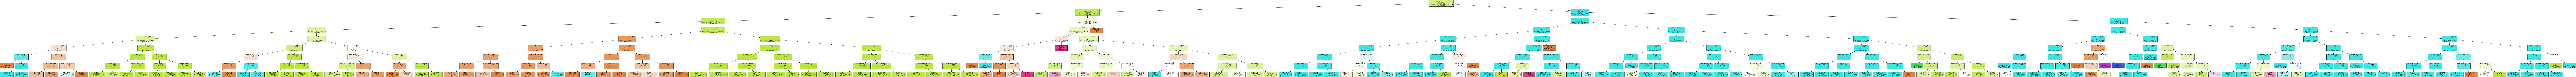

In [46]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_train.columns,
    class_names=['Current', 'Fully Paid', 'Charged Off', 'Late (31-120 days)',
                 'In Grace Period', 'Default', 'Late (16-30 days)'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Build Random Forest Model

In [53]:
# Set features and target
X = num_variables
Y = y2015['loan_status']

In [54]:
# Start time
start = time.time()

# Initialize and train tree
rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, y_train)

# End time
end = time.time()

# Test model by calculating accuracy on test set
y_pred = rfc.predict(X_test)
score = accuracy_score(y_test, y_pred)

print('Accuracy: ', score)
print('Runtime: ', end - start, 'seconds')

/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy:  0.9629299801707453
Runtime:  27.021547079086304 seconds


## Conclusion
The accuracies of the two models are quite similar, with the Decision Tree giving an accuracy of 94.3% and the Random Forest giving a slightly better accuracy of 96.3%. However, the Decision Tree had a much shorter runtime of just 2.76 seconds compared to 27.02 seconds for the Random Forest. The main caveat here is that the GridSearchCV used to optimize the Decision Tree took a very long time to run (much longer than the difference in runtime of the two models).